In [2]:
import numpy as np
import pandas as pd
import time, math
import matplotlib.pyplot as plt
from itertools import combinations, product

In [3]:
def display(input_data, plot_c_values=False):
    print("################################################################################################\n")
    print(" vs ".join(input_data[0]["Basis Functions"])+"\n")
    print("Time taken: {} seconds\n".format(input_data[0]["Time Taken"]))

    for rule_index, output in enumerate(input_data):
        total_points = output["Total Points"]
        total_clusters = output["Total Clusters"]
        total_clustered_points = output["Total Clustered Points"]

        print("Rule {}:-\n".format(rule_index+1))

        print("Equation:   {}\n".format(output["Equation"]))

        print("Total Significance:   {}% ({} points out of {})\n"
              .format(output["Total Significance"], output["Total Clustered Points"], total_points))

        output["Total Significance"] = total_clustered_points*100/total_points
        output["Total Clustered Points"] = total_clustered_points

        total_clusters = len(output["Clusters"])
        for cluster_index, cluster in enumerate(output["Clusters"]):
            print("Cluster {}/{}:-".format(cluster_index+1, total_clusters))
            print("C:   {}".format(cluster["C"]))
            print("Significance:   {}% ({} points out of {})\n".format(
                cluster["Significance"], cluster["Clustered Points"], total_points))

        if plot_c_values:
            graph_data = output["Graph Data"]
            plt.scatter(graph_data["Clustered C Index"], graph_data["Clustered C"], 10, color='k', label='Clustered Point')
            plt.scatter(graph_data["Unclustered C Index"], graph_data["Unclustered C"], 20, facecolors='none', edgecolors='k', label='Unclustered Point')
            plt.locator_params(integer=True)
            plt.xlabel('Data Points', fontsize=14)
            plt.ylabel('c Values', fontsize=14)
            plt.tight_layout()
            plt.legend()
            plt.show()

    print("################################################################################################\n")


In [4]:
class AutomatedInnovization:
    
    def __init__(self, dataset=None, basis_functions=None, drop_duplicates=False, plot_c_values=False, discover_additional_rules=False):
        if len(basis_functions) > 1:
            self.data = np.log(dataset[basis_functions]).groupby(basis_functions).size().reset_index()
        else:
            self.data = dataset[basis_functions].groupby(basis_functions).size().reset_index()
#         self.basis_functions = list(self.data[basis_functions].nunique().sort_values(ascending=False).index)
        self.basis_functions = basis_functions
        self.data = self.data[[0] + self.basis_functions]
        self.data.columns = ["Frequency"] + self.basis_functions
        self.discover_additional_rules = discover_additional_rules
        if drop_duplicates:
            self.data["Frequency"] = 1
        self.frequencies = self.data["Frequency"].values
        self.cluster_threshold = 3
        self.plot_c_values = plot_c_values
        self.index = self.basis_functions.index(basis_functions[0])
        self.output = []
        
    
    def display(self):
        display(self.output, self.plot_c_values)
        return self
    
    
    def __formatOutput(self, gradient, total_points, counter, constants):
        total_clusters = sum(counter >= self.cluster_threshold)
        total_clustered_points = sum(counter[counter >= self.cluster_threshold])
        
        output = {
            "Time Taken": self.time_taken,
            "Basis Functions": self.basis_functions,
            "Total Points": total_points,
            "Total Clusters": total_clusters,
            "Total Clustered Points": total_clustered_points,
        }
        
        output["Equation"] = "{} = C".format(" * ".join(map("{}^({})".format, self.basis_functions, gradient)))
        output["Rule"] = []
        for bf, power in zip(self.basis_functions, gradient):
            output["Rule"].append({
                "Variable": bf,
                "Power": power,
            })
        
        output["Total Significance"] = total_clustered_points*100/total_points
        
        clustered_c_index, clustered_c, unclustered_c_index, unclustered_c = [], [], [], []
        loop_index, cluster_index = 1, 1
          
        output["Clusters"] = []
        
        for constant, count in zip(constants, counter):
            
            if count >= self.cluster_threshold:
                
                cluster_index += 1
                
                output["Clusters"].append({
                    "C": constant,
                    "Significance": count*100/total_points,
                    "Clustered Points": count,
                })
                
                for loop_index in range(loop_index, loop_index + count):
                    clustered_c.append(constant)
                    clustered_c_index.append(loop_index)
            else:
                for loop_index in range(loop_index, loop_index + count):
                    unclustered_c.append(constant)
                    unclustered_c_index.append(loop_index)
            loop_index += 1
        
        output["Graph Data"] = {
            "Clustered C Index": clustered_c_index,
            "Clustered C": clustered_c,
            "Unclustered C Index": unclustered_c_index,
            "Unclustered C": unclustered_c,
        }
        
        self.output.append(output)
    
    
    def __getGradients(self):
        gradient_list = [[] for i in self.basis_functions[1:]]
        counts = []
        
        for i, j in combinations(self.data.values, 2):
            x1, x2 = i[1], j[1]
            counts.append(i[0]*j[0])
            
            for index, (y1, y2) in enumerate(zip(i[2:], j[2:])):
                if y1 == y2:
                    gradient_list[index].append(0)
                elif x1 == x2:
                    gradient_list[index].append(90)
                else:
                    gradient_list[index].append(math.degrees(math.atan((y2 - y1)/(x2 - x1))))
        
        return np.array(gradient_list), np.array(counts).astype(int)
    
    
    def __getConstants(self, gradient):
        c = np.repeat((self.data[self.basis_functions].values * gradient).sum(axis = 1), 3)
        counts = np.repeat(self.frequencies, 3)
        
        for index, (constant, count) in enumerate(sorted(zip(c, counts))):
            c[index] = constant
            counts[index] = count
        
        total_points = sum(counts)
        dc = np.gradient(c)
        std = np.std(dc)
        
        threshold = int(math.sqrt(len(c)))
        leftover = len(c) - threshold**2
        
        clusters = [0]
        
        cluster_start_index = 0
        
        for i in range(threshold):
            cluster_end_index = cluster_start_index + threshold + 1 if i < leftover else cluster_start_index + threshold
            std_coef = np.std(dc[cluster_start_index:cluster_end_index])
            
            if math.sqrt(3)*std_coef < std:
                std_coef = std
            upper_limit = math.sqrt(3)*std_coef
            
            for j in range(cluster_start_index, cluster_end_index):
                if dc[j] > upper_limit and j%3 == 0:
                    clusters.append(j)
            cluster_start_index = cluster_end_index
        
        clusters.append(len(c))
        
        constants = []
        counter = []
        for i in range(len(clusters) - 1):
            start, end = clusters[i], clusters[i+1]
            if start != end+1:
                value_to_append = sum(c[start:end]*counts[start:end])/sum(counts[start:end])
                if len(self.basis_functions) > 1:
                    value_to_append = math.e**value_to_append
                constants.append(value_to_append)
                counter.append(sum(counts[start:end])//3)
        
        return total_points//3, np.array(counter).astype(int), np.array(constants)
    
    
    def __getLimits(self, buckets):
        limit_list = []
        minimum_limit_threshold = sum(self.frequencies)
        
        for bucket in buckets:
            safe_bucket = [0, 0] + bucket + [0, 0]
            limits = [[-1, -2]]

            for i in range(0, len(bucket) - 1):
                above_limit_threshold = i > limits[-1][1]+1 and max(safe_bucket[i+2], safe_bucket[i+3]) > minimum_limit_threshold
                is_local_maxima = safe_bucket[i+2]+safe_bucket[i+3] > max(safe_bucket[i]+safe_bucket[i+1], safe_bucket[i+4]+safe_bucket[i+5])
                
                if above_limit_threshold and is_local_maxima:
                    limits.append([(safe_bucket[i+2]+safe_bucket[i+3])/2, i])
            
            limit_list.append([i[1] for i in sorted(limits[1:], reverse=True)])
            
        return limit_list

    
    def Result(self):
        return self.output
        
        
    def findRules(self):
        if len(self.data) == 0:
            return self
        
        start_time = time.time()
        
        if len(self.basis_functions) == 1:
            gradient = [1]
            total_points, counter, constants = self.__getConstants(gradient)
            self.time_taken = time.time() - start_time
            self.__formatOutput(gradient, total_points, counter, constants)
            return self
        
        result_index = self.basis_functions
        power_list = [[1]]
        
        gradient_list, counts = self.__getGradients()

        maximas, minimas = [max(i) for i in gradient_list], [min(i) for i in gradient_list]
        bucket_size = int(math.sqrt(len(gradient_list[0])))
        
        buckets = [[0 for i in range(bucket_size)] for j in range(len(self.basis_functions) - 1)]
        
        for bucket_index, (gradients, maxima, minima) in enumerate(zip(gradient_list, maximas, minimas)):
            for i, j in zip(gradients, counts):
                index = min(int(((i-minima)*bucket_size)/(maxima-minima)), bucket_size-1)
                buckets[bucket_index][index] += j
        
        limit_list = self.__getLimits(buckets)
        
        if not self.discover_additional_rules:
            limit_list = [[i[0]] for i in limit_list]
        
        for limits, gradients, maxima, minima, x in zip(limit_list, gradient_list, maximas, minimas, self.basis_functions[1:]):
            
            powers = []
            
            for limit in limits:
                upper_limit, lower_limit = minima + (maxima-minima)*(limit+2)/bucket_size, minima + (maxima-minima)*(limit)/bucket_size
                bucket_gradients = gradients[(gradients <= upper_limit) & (gradients >= lower_limit)]
                bucket_counts = counts[(gradients <= upper_limit) & (gradients >= lower_limit)]

                while True:

                    bucket_maximum, bucket_minimum = max(bucket_gradients), min(bucket_gradients)

                    threshold = int(math.sqrt(len(bucket_gradients)))

                    if threshold <= 3 or bucket_minimum == bucket_maximum:
                        current_gradient = sum(bucket_gradients*bucket_counts)/sum(bucket_counts)
                        break

                    buckets = [0 for i in range(threshold)]

                    for bg, bc in zip(bucket_gradients, bucket_counts):
                        index = min(int(((bg - bucket_minimum)*threshold)/(bucket_maximum - bucket_minimum)), threshold-1)
                        buckets[index] += bc
                    
                    cap_index = buckets.index(max(buckets))
                    
                    upper_limit = bucket_minimum + (bucket_maximum - bucket_minimum)*(cap_index+2)/threshold
                    lower_limit = bucket_minimum + (bucket_maximum - bucket_minimum)*(cap_index-1)/threshold
                    
                    bucket_counts = bucket_counts[(bucket_gradients <= upper_limit) & (bucket_gradients >= lower_limit)]
                    bucket_gradients = bucket_gradients[(bucket_gradients <= upper_limit) & (bucket_gradients >= lower_limit)]
                
                if current_gradient != 0:
                    powers.append(1 / np.float64(math.tan(- current_gradient * math.pi / 180)))
            
            power_list.append(powers)
        
        rules = []

        power_list = list(product(*power_list))
        
        for powers in power_list:
            rule = np.array(list(powers))/powers[self.index]
            rules.append((rule, self.__getConstants(rule)))
        
        self.time_taken = time.time() - start_time

        for (gradient, (total_points, counter, constants)) in rules:
            self.__formatOutput(gradient, total_points, counter, constants)
            
        return self


In [5]:
class SimultaneousDiscovery:
    
    def __init__(self, dataset, plot_c_values=False):
        self.data = dataset
        self.basis_functions = dataset.columns
        self.valid_rules = []
        self.solutions_to_find = len(self.basis_functions) + 1
        self.output = []
        self.plot_c_values = plot_c_values
    
    
    def __isValid(self, rules):
        for rule in rules:
            for cluster in rule["Clusters"]:
                if cluster["Significance"] > 70:
                    return True
        return False

    
    def __isRedundant(self, rule):
        rule = set(rule)
        for existing_rule in self.valid_rules:
            if existing_rule.issubset(rule):
                return True
        return False
    
    
    def display(self):
        print("Total Rules Found : {}".format(len(self.output)))
        for result in self.output:
            display(result, self.plot_c_values)
        
        
    def findRules(self):
        explored_basis_functions = set()
        for num_combinations in range(1, len(self.basis_functions) + 1):
            self.solutions_to_find -= 1
            if self.solutions_to_find <= 0:
                break
            for rule in combinations(self.basis_functions, num_combinations):
                if self.solutions_to_find <= 0:
                    break
                rule = list(rule)
                if self.__isRedundant(rule) or set(rule).issubset(explored_basis_functions):
                    continue
                result = AutomatedInnovization(dataset=self.data, basis_functions=rule).findRules().Result()
                if self.__isValid(result):
                    self.valid_rules.append(set(rule))
                    explored_basis_functions = explored_basis_functions.union(set(rule))
                    self.solutions_to_find -= 1
                    self.output.append(result)

        return self
        

# ZDT1

In [ ]:
data = pd.read_csv("datasets/zdt1.csv")
SimultaneousDiscovery(dataset=data).findRules().display()

/root/.BTP/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


In [194]:
data = pd.read_csv("datasets/zdt_1.csv")
SimultaneousDiscovery(dataset=data).findRules().display()

Total Rules Found : 6
################################################################################################

x2

Time taken: 0.002481698989868164 seconds

Rule 1:-

Equation:   x2^(1) = C

Total Significance:   99.33333333333333% (298 points out of 300)

Cluster 1/1:-
C:   0.5000046825603609
Significance:   99.33333333333333% (298 points out of 300)

################################################################################################

################################################################################################

x3

Time taken: 0.0025606155395507812 seconds

Rule 1:-

Equation:   x3^(1) = C

Total Significance:   98.66666666666667% (296 points out of 300)

Cluster 1/2:-
C:   0.7037947561321964
Significance:   97.66666666666667% (293 points out of 300)

Cluster 2/2:-
C:   0.7061752518083328
Significance:   1.0% (3 points out of 300)

################################################################################################

###############

AttributeError: 'NoneType' object has no attribute 'findRules'

# ZDT2

In [177]:
data = pd.read_csv("datasets/zdt2.csv")
SimultaneousDiscovery(dataset=data).findRules().display()

Total Rules Found : 4
################################################################################################

x1 vs x2

Time taken: 0.24151229858398438 seconds

Rule 1:-

Equation:   x1^(1.0) * x2^(1.0004708698386806) = C

Total Significance:   97.33333333333333% (292 points out of 300)

Cluster 1/10:-
C:   0.4924335922710899
Significance:   3.0% (9 points out of 300)

Cluster 2/10:-
C:   0.49403551295117903
Significance:   2.3333333333333335% (7 points out of 300)

Cluster 3/10:-
C:   0.4951442008482468
Significance:   1.0% (3 points out of 300)

Cluster 4/10:-
C:   0.4956308279971348
Significance:   1.3333333333333333% (4 points out of 300)

Cluster 5/10:-
C:   0.4961214024315284
Significance:   2.6666666666666665% (8 points out of 300)

Cluster 6/10:-
C:   0.4996042558754097
Significance:   80.66666666666667% (242 points out of 300)

Cluster 7/10:-
C:   0.5028746545065417
Significance:   1.3333333333333333% (4 points out of 300)

Cluster 8/10:-
C:   0.5035029620921082
Sign

# ZDT3

In [178]:
data = pd.read_csv("datasets/zdt3.csv")
SimultaneousDiscovery(dataset=data).findRules().display()

Total Rules Found : 4
################################################################################################

x5

Time taken: 0.0024597644805908203 seconds

Rule 1:-

Equation:   x5^(1) = C

Total Significance:   100.0% (300 points out of 300)

Cluster 1/2:-
C:   0.4999992323299299
Significance:   99.0% (297 points out of 300)

Cluster 2/2:-
C:   0.500069277441909
Significance:   1.0% (3 points out of 300)

################################################################################################

################################################################################################

x1 vs x2

Time taken: 0.2433631420135498 seconds

Rule 1:-

Equation:   x1^(1.0) * x2^(1.0004231647479342) = C

Total Significance:   97.66666666666667% (293 points out of 300)

Cluster 1/8:-
C:   0.497055191227368
Significance:   1.6666666666666667% (5 points out of 300)

Cluster 2/8:-
C:   0.4979846138348208
Significance:   1.0% (3 points out of 300)

Cluster 3/8:-
C:   0.498176

In [77]:
data = np.log(pd.read_csv("datasets/zdt1.csv"))

/root/.BTP/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


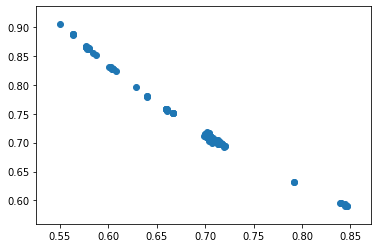

In [82]:
plt.scatter(data["x3"], data["x4"])
plt.show()

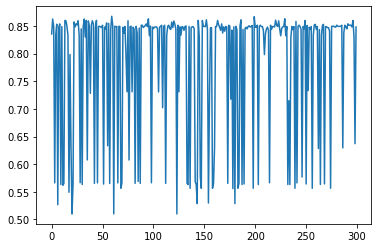

In [83]:
plt.plot(data["x5"])